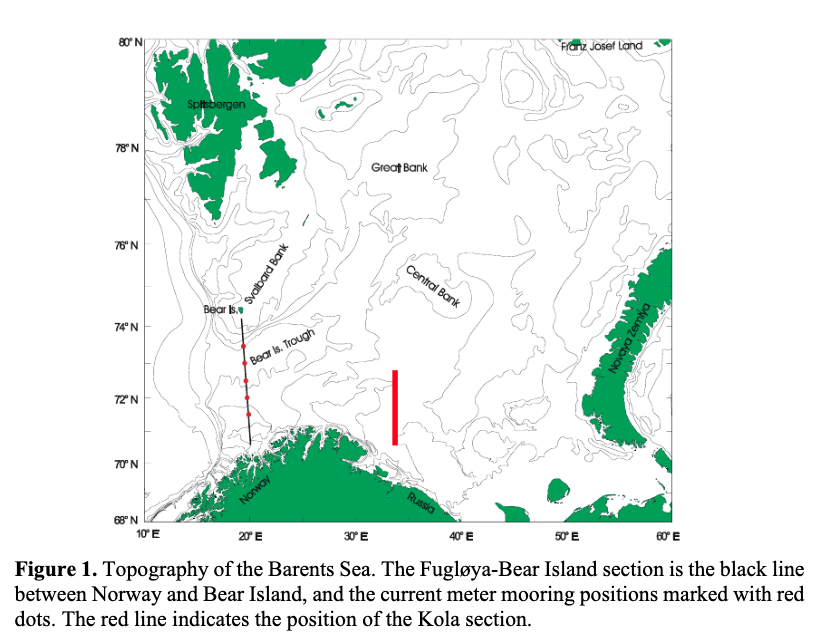


In [1]:
import copernicusmarine
import xarray as xr
import fsspec
import pandas as pd
from seapopym.standard.units import StandardUnitsLabels

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LONGITUDE = 20
LATITUDE_MIN = 70
LATITUDE_MAX = 74
START_TIME = "1987-01-01"
END_TIME = "2017-12-31"
DELTA_IMPORT = 0.5
DELTA_COMPUTE = 0.1

## Load DATA


### CMEMS


In [3]:
FROM_API = True
path_cmems_product_bio = "..."
path_cmems_product_physic = "..."

In [4]:
# copernicusmarine.login()

coordinates = {
    "minimum_latitude": LATITUDE_MIN,
    "maximum_latitude": LATITUDE_MAX,
    "minimum_longitude": LONGITUDE - DELTA_IMPORT,
    "maximum_longitude": LONGITUDE + DELTA_IMPORT,
    "start_datetime": START_TIME,
    "end_datetime": END_TIME,
}


if FROM_API:
    bio = copernicusmarine.open_dataset(dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i", **coordinates)
    bio.load()
    physic = copernicusmarine.open_dataset(dataset_id="cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i", **coordinates)
    physic.load()
else:
    bio = xr.load_dataset(path_cmems_product_bio)
    physic = xr.load_dataset(path_cmems_product_physic)

INFO - 2025-01-22T10:08:13Z - Selected dataset version: "202411"
INFO - 2025-01-22T10:08:13Z - Selected dataset part: "default"
WARNING - 2025-01-22T10:08:15Z - Some of your subset selection [1987-01-01 00:00:00+00:00, 2017-12-31 00:00:00+00:00] for the time dimension exceed the dataset coordinates [1998-01-01 00:00:00+00:00, 2023-12-31 00:00:00+00:00]
INFO - 2025-01-22T10:08:48Z - Selected dataset version: "202411"
INFO - 2025-01-22T10:08:48Z - Selected dataset part: "default"
WARNING - 2025-01-22T10:08:50Z - Some of your subset selection [1987-01-01 00:00:00+00:00, 2017-12-31 00:00:00+00:00] for the time dimension exceed the dataset coordinates [1998-01-01 00:00:00+00:00, 2023-12-31 00:00:00+00:00]


In [5]:
with xr.set_options(keep_attrs=True):
    data = xr.merge([bio, physic])
    lat_attrs, lon_attrs = data.latitude.attrs, data.longitude.attrs
    data = data.sel(
        time=slice(START_TIME, END_TIME),
    ).sel(
        latitude=slice(LATITUDE_MIN, LATITUDE_MAX),
        longitude=slice(LONGITUDE - DELTA_COMPUTE, LONGITUDE + DELTA_COMPUTE),
    )
    data = data.mean(dim=["longitude"], skipna=True)
    data = data.expand_dims({"longitude": [LONGITUDE]})
    data.latitude.attrs, data.longitude.attrs = lat_attrs, lon_attrs
    data["T"].attrs["units"] = str(StandardUnitsLabels.temperature.units)
data

<xarray.Dataset> Size: 80MB
Dimensions:              (longitude: 1, latitude: 65, time: 7305, depth: 3)
Coordinates:
  * longitude            (longitude) int64 8B 20
  * latitude             (latitude) float32 260B 70.0 70.08 70.08 ... 73.92 74.0
  * time                 (time) datetime64[ns] 58kB 1998-01-01 ... 2017-12-31
  * depth                (depth) int32 12B 1 2 3
Data variables: (12/13)
    mnkc_epi             (longitude, time, latitude) float64 4MB 63.75 ... 2.928
    mnkc_hmlmeso         (longitude, time, latitude) float64 4MB nan nan ... nan
    mnkc_lmeso           (longitude, time, latitude) float64 4MB nan nan ... nan
    mnkc_mlmeso          (longitude, time, latitude) float64 4MB nan nan ... nan
    mnkc_mumeso          (longitude, time, latitude) float64 4MB nan nan ... nan
    mnkc_umeso           (longitude, time, latitude) float64 4MB nan nan ... nan
    ...                   ...
    zeu                  (longitude, time, latitude) float64 4MB 96.81 ... 104.2
    zooc                 (longitude, time, latitude) float64 4MB 6.845 ... 0....
    T                    (longitude, time, depth, latitude) float64 11MB 4.71...
    U                    (longitude, time, depth, latitude) float64 11MB -0.0...
    V                    (longitude, time, depth, latitude) float64 11MB -0.0...
    pelagic_layer_depth  (longitude, time, depth, latitude) float64 11MB 145....
Attributes:
    history:      Created on 2024-10-17
    source:       SEAPODYM-LMTL 3.0.0
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    title:        Global ocean low and mid trophic levels biomass content hin...
    Conventions:  CF-1.7

In [6]:
data = data[["npp", "T", "pelagic_layer_depth", "zooc", "zeu"]].isel(depth=[0, 1]).dropna("latitude")
data

<xarray.Dataset> Size: 12MB
Dimensions:              (longitude: 1, time: 7305, latitude: 28, depth: 2)
Coordinates:
  * longitude            (longitude) int64 8B 20
  * latitude             (latitude) float32 112B 70.5 70.67 ... 73.75 73.92
  * time                 (time) datetime64[ns] 58kB 1998-01-01 ... 2017-12-31
  * depth                (depth) int32 8B 1 2
Data variables:
    npp                  (longitude, time, latitude) float64 2MB 3.654e-06 .....
    T                    (longitude, time, depth, latitude) float64 3MB 6.29 ...
    pelagic_layer_depth  (longitude, time, depth, latitude) float64 3MB 143.6...
    zooc                 (longitude, time, latitude) float64 2MB 1.166 ... 0....
    zeu                  (longitude, time, latitude) float64 2MB 95.74 ... 104.5
Attributes:
    history:      Created on 2024-10-17
    source:       SEAPODYM-LMTL 3.0.0
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    title:        Global ocean low and mid trophic levels biomass content hin...
    Conventions:  CF-1.7

In [7]:
data.isnull().sum()

<xarray.Dataset> Size: 40B
Dimensions:              ()
Data variables:
    npp                  int64 8B 0
    T                    int64 8B 0
    pelagic_layer_depth  int64 8B 0
    zooc                 int64 8B 0
    zeu                  int64 8B 0

In [8]:
with xr.set_options(keep_attrs=True):
    data = data.mean(dim=["depth", "latitude"]).expand_dims({"latitude": [72]})
    data["T"] = data["T"].expand_dims({"depth": [0]})
    data.depth.attrs = physic.depth.attrs
    data.latitude.attrs = physic.latitude.attrs
data

<xarray.Dataset> Size: 351kB
Dimensions:              (latitude: 1, longitude: 1, time: 7305, depth: 1)
Coordinates:
  * latitude             (latitude) int64 8B 72
  * longitude            (longitude) int64 8B 20
  * time                 (time) datetime64[ns] 58kB 1998-01-01 ... 2017-12-31
  * depth                (depth) int64 8B 0
Data variables:
    npp                  (latitude, longitude, time) float64 58kB 3.654e-06 ....
    T                    (depth, latitude, longitude, time) float64 58kB 5.20...
    pelagic_layer_depth  (latitude, longitude, time) float64 58kB 300.7 ... 3...
    zooc                 (latitude, longitude, time) float64 58kB 0.8288 ... ...
    zeu                  (latitude, longitude, time) float64 58kB 100.2 ... 1...
Attributes:
    history:      Created on 2024-10-17
    source:       SEAPODYM-LMTL 3.0.0
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    title:        Global ocean low and mid trophic levels biomass content hin...
    Conventions:  CF-1.7

In [9]:
data.to_zarr("Barents_sea_forcing.zarr", mode="w")